In [3]:
import numpy as np
import pandas as pd

Definimos las variables

In [23]:
N = 4 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 3/12 # Delta t
sigma = 0.0016835430755297832 # Volatilidad

In [25]:
r[0][0] = 0.04761 # Tasa inicial
Q[0][0] = 1 # Precio inicial

# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    P = np.array(discount_factors)

theta[0] = ((-(2*P[1]-1)+np.sqrt(1 + 4 * P[1]**2 * dt**3 * sigma**2) )/ (2*P[1]*dt) - r[0][0])/dt

Tasas nivel 1

In [26]:
r[1][1] = r[0][0] + theta[0]*dt + sigma*np.sqrt(dt)
r[0][1] = r[0][0] + theta[0]*dt - sigma*np.sqrt(dt)

Funciones para despejar theta

In [27]:
# Factor de descuento
def disc_factor(r: float, dt: float)->float:
    return 1 / (1 + dt*r)

def ab_ident(theta: float, j: int, P: list, Q : list, r: list, dt: float, sigma: float)->float:

    s = sigma * np.sqrt(dt)
    
    value = 0.5 * Q[0][j] * disc_factor(r[0][j] + theta*dt - s, dt)
    value += 0.5 * Q[j][j] * disc_factor(r[j][j] + theta*dt + s, dt)

    middle_nodes = [(Q[i-1][j] + Q[i][j])*disc_factor(r[i][j] + theta*dt, dt) for i in range(1, j+1)] # -s
    value += 0.5 * sum(middle_nodes)
    value -= P[j+1]

    return value
    
def ab_ident_deriv(theta: float, j: int, P: list, Q : list, r: list, dt: float, sigma: float)->float:
    s = sigma * np.sqrt(dt)
    value = (-0.5) * (dt**2) * Q[0][j] * disc_factor(r[0][j] + theta*dt - s, dt)**2
    value -= 0.5 * (dt**2) * Q[j][j] * disc_factor(r[j][j] + theta*dt + s, dt)**2

    middle_nodes = [(Q[i-1][j] + Q[i][j])*disc_factor(r[i][j]+theta*dt, dt)**2 for i in range(1, j+1)] # -s 
    value -= 0.5 * (dt**2) * sum(middle_nodes)
    return value


Función Newton-Rahpson

In [28]:
def newton_raphson(j, P, Q, r, dt, sigma, 
                   theta0=0.0, tol=1e-12, max_iter=50):
    theta = theta0
    for _ in range(max_iter):
        F  = ab_ident(theta, j, P, Q, r, dt, sigma)
        dF = ab_ident_deriv(theta, j, P, Q, r, dt, sigma)

        if abs(dF) < 1e-18:
            break

        step = F / dF

        # backtracking line search
        t = 1.0
        while t > 1e-6:
            cand = theta - t*step

            # chequear positividad de todos los denominadores
            s = sigma*np.sqrt(dt)
            ok = True
            if 1.0 + dt*(r[0][j] + cand*dt - s) <= 0: ok = False
            if 1.0 + dt*(r[j][j] + cand*dt + s) <= 0: ok = False
            for i in range(1, j):
                if 1.0 + dt*(r[i][j] + cand*dt) <= 0: ok = False

            if ok and abs(ab_ident(cand, j, P, Q, r, dt, sigma)) <= abs(F):
                theta = cand
                break

            t *= 0.5
        else:
            # no mejoró: damos el paso completo igualmente para no quedarnos colgados
            theta = theta - step

        if abs(step) < tol and abs(F) < tol:
            break

    return theta


In [29]:
for j in range(1,N):
    # Precios Arrow-Debreu
    for i in range(0, j+1):
        if i == 0:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * Q[i][j-1]
        elif i == j:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * Q[j-1][j-1]
        else:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * (Q[i-1][j-1] + Q[i][j-1])
    
    # theta
    theta[j] = newton_raphson(j, P, Q, r, dt, sigma)

    # Tasas
    for i in range(0, j+1):
        r[i][j+1] = r[i][j] + theta[j]*dt - sigma*np.sqrt(dt)
    r[j+1][j+1] = r[j][j] + theta[j]*dt + sigma*np.sqrt(dt)

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(r: np.ndarray, dt: float, title="Lattice de Ho–Lee"):
    """
    r: matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
       r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt: tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt

    fig, ax = plt.subplots(figsize=(10, 5))

    # Dibujar aristas (padre j -> hijos en j+1)
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i, j+1]],
                        color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i+1, j+1]],
                        color="red", lw=0.8)

    # (Opcional) marcar nodos
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # Formato ejes
    ax.set_xlim(T[0], T[-1])
    ymin = np.nanmin(r); ymax = np.nanmax(r)
    ylim = max(abs(ymin), abs(ymax))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) and ymax != ymin else 0.02)
    ax.set_ylim(-ylim - pad, ylim + pad)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra % (r en decimal)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (Años)")
    ax.set_ylabel("Tasa")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

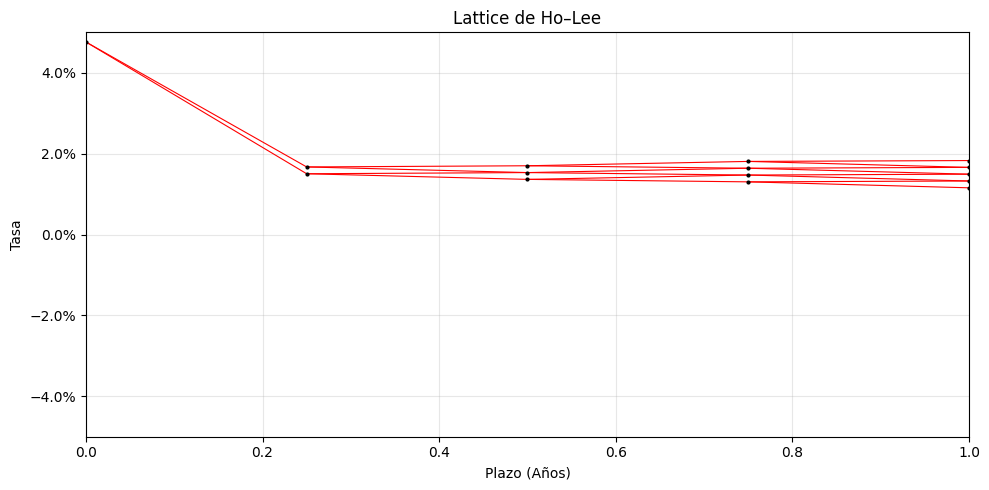

In [31]:
plot_ho_lee_lattice(r, dt)

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado (NR) a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

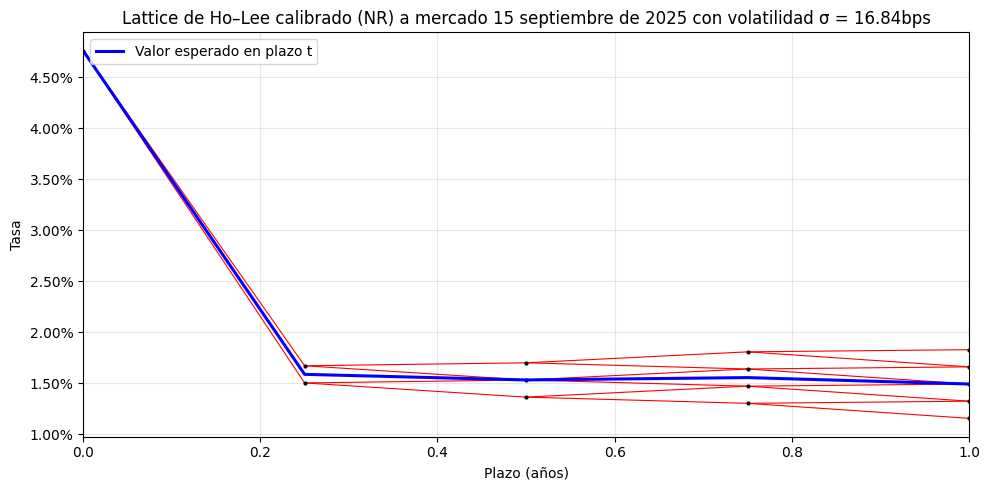

In [34]:
s = sigma
plot_ho_lee_lattice(r, dt=dt, sigma = s, mostrar_esperanza=True)

In [154]:
theta - np.array([-1.24977495e-03, -3.48326234e-03, -6.70918351e-04, -2.62088841e-02,
        1.12878814e-03,  3.30015903e-03, -1.13870823e-02,  1.84567576e-03,
        2.05711952e-03, -1.43808431e-02,  1.89266776e-03,  1.93011830e-03,
       -1.16290340e-02,  1.84692529e-03,  1.86268456e-03,  1.87487806e-03,
        1.88870817e-03,  1.90264208e-03,  3.44608153e-03,  1.94219682e-03,
        1.95670987e-03,  1.97139230e-03,  1.98623629e-03,  2.00124591e-03,
        1.27358551e-02,  2.11328902e-03,  2.12973963e-03,  2.14637904e-03,
        2.16320910e-03,  2.18023302e-03,  2.19745379e-03,  2.21487447e-03,
        2.23249820e-03,  2.25032819e-03,  2.26836771e-03,  2.28662010e-03,
       -3.55364880e-03,  2.27684864e-03,  2.29519423e-03,  2.31375758e-03,
        2.33254221e-03,  2.35155169e-03,  2.37078967e-03,  2.39025987e-03,
        2.40996610e-03,  2.42991223e-03,  2.45010221e-03,  2.47054009e-03,
        8.71550807e-05,  2.49209712e-03,  2.51305117e-03,  2.53426589e-03,
        2.55574566e-03,  2.57749496e-03,  2.59951838e-03,  2.62182059e-03,
        2.64440637e-03,  2.66728060e-03,  2.69044827e-03,  2.71391446e-03,
        0.00000000e+00])

array([ 1.13001021e-03, -4.07951602e-03,  2.88574667e-03,  4.58226395e-04,
        1.27662752e-03, -1.06218817e-03,  2.05112526e-04,  1.87283236e-04,
       -3.24015770e-05, -2.95236372e-05,  2.42331023e-05, -2.51937078e-06,
       -4.03694854e-05,  8.71050892e-06,  5.63092754e-06,  6.98493807e-06,
        6.93824229e-06,  6.98132031e-06,  1.27190636e-05,  7.13725872e-06,
        7.28749726e-06,  7.36954904e-06,  7.45372399e-06,  7.53768011e-06,
        4.86612352e-05,  7.73975457e-06,  8.26401197e-06,  8.35789689e-06,
        8.45344138e-06,  8.55040705e-06,  8.64885612e-06,  8.74884464e-06,
        8.85041075e-06,  8.95358657e-06,  9.05840919e-06,  9.16491166e-06,
       -1.43344605e-05,  9.33730639e-06,  9.20911728e-06,  9.31809655e-06,
        9.42882840e-06,  9.54136480e-06,  9.65574134e-06,  9.77199949e-06,
        9.89016692e-06,  1.00102910e-05,  1.01324194e-05,  1.02565837e-05,
        2.87895050e-07,  1.04823407e-05,  1.05142041e-05,  1.06448030e-05,
        1.07776170e-05,  

In [18]:
m = N
# llamamos a TUS funciones (se asume que están definidas en tu entorno)
pascal_factors = pascal_factors_funct(m+1)
mu_cal = esperanza(m, r, pascal_factors)  # vector de largo m+1
mu_exp = [0.04761   , 0.04750585, 0.04721558, 0.04715967, 0.0449756 ,
       0.04506966, 0.04534468, 0.04439575, 0.04454956, 0.04472099,
       0.04352258, 0.0436803 , 0.04384115, 0.04287206, 0.04302597,
       0.04318119, 0.04333743, 0.04349483, 0.04365338, 0.04394055,
       0.0441024 , 0.04426546, 0.04442975, 0.04459527, 0.04476204,
       0.04582336, 0.04599946, 0.04617694, 0.04635581, 0.04653608,
       0.04671776, 0.04690088, 0.04708546, 0.0472715 , 0.04745902,
       0.04764805, 0.04783861, 0.04754247, 0.04773221, 0.04792347,
       0.04811629, 0.04831066, 0.04850663, 0.04870419, 0.04890338,
       0.04910421, 0.0493067 , 0.04951088, 0.04971676, 0.04972402,
       0.0499317 , 0.05014112, 0.05035231, 0.05056528, 0.05078008,
       0.0509967 , 0.05121519, 0.05143555, 0.05165783, 0.05188203,
       0.05210819, 0.05144408, 0.05166646, 0.05189078, 0.05211705,
       0.05234531, 0.05257557, 0.05280786, 0.05304221, 0.05327866,
       0.05351721, 0.05375791, 0.05400078, 0.05424585, 0.05449315,
       0.05474271, 0.05499457, 0.05524874, 0.05550527, 0.05576419,
       0.05602553, 0.05628932, 0.0565556 , 0.0568244 , 0.05709577,
       0.05314725, 0.05338473, 0.05362434, 0.0538661 , 0.05411004,
       0.05435619, 0.05460458, 0.05485525, 0.05510821, 0.05536351,
       0.05562117, 0.05588123, 0.05614373, 0.05640869, 0.05667615,
       0.05694614, 0.05721871, 0.05749388, 0.0577717 , 0.0580522 ,
       0.05833543, 0.05862141, 0.0589102 , 0.05920183, 0.05949635,
       0.05979379, 0.0600942 , 0.06039763, 0.06070413, 0.06101372,
       0.06132648, 0.06164243, 0.06196164, 0.06228415, 0.06261002,
       0.06293929, 0.05641443, 0.05668193, 0.05695195, 0.05722455,
       0.05749974, 0.05777757, 0.05805808, 0.05834131, 0.05862729,
       0.05891607, 0.05920768, 0.05950217, 0.05979958, 0.06009995,
       0.06040334, 0.06070977, 0.06101931, 0.06133199, 0.06164787,
       0.06196699, 0.0622894 , 0.06261516, 0.06294432, 0.06327693,
       0.05503489, 0.05528941, 0.05554628, 0.05580551, 0.05606715,
       0.05633124, 0.05659779, 0.05686685, 0.05713846, 0.05741264,
       0.05768945, 0.0579689 , 0.05825105, 0.05853593, 0.05882357,
       0.05911403, 0.05940734, 0.05970355, 0.06000269, 0.06030482,
       0.06060997, 0.06091819, 0.06122953, 0.06154404, 0.06186175,
       0.06218274, 0.06250703, 0.06283469, 0.06316577, 0.06350032,
       0.0638384 , 0.06418006, 0.06452535, 0.06487435, 0.0652271 ,
       0.06558367, 0.04991544, 0.05012482, 0.05033593, 0.0505488 ,
       0.05076345, 0.0509799 , 0.05119817, 0.05141829, 0.05164028,
       0.05186416, 0.05208996, 0.05231771, 0.05254742, 0.05277912,
       0.05301284, 0.05324861, 0.05348645, 0.05372639, 0.05396846,
       0.05421268, 0.05445909, 0.05470771, 0.05495858, 0.05521172,
       0.05546716, 0.05572495, 0.0559851 , 0.05624766, 0.05651265,
       0.05678011, 0.05705008, 0.05732258, 0.05759766, 0.05787535,
       0.0581557 , 0.05843873, 0.05872449, 0.05901301, 0.05930434,
       0.05959852, 0.05989559, 0.06019559, 0.06049857, 0.06080457,
       0.06111364, 0.06142582, 0.06174115, 0.0620597 , 0.06238151,
       0.06270662, 0.0630351 , 0.06336699, 0.06370234, 0.06404121,
       0.06438366, 0.06472974, 0.06507952, 0.06543305, 0.06579038,
       0.0661516 , 0.04806039, 0.04825382, 0.04844878, 0.04864528,
       0.04884334, 0.04904299, 0.04924423, 0.04944709, 0.04965158,
       0.04985774, 0.05006557, 0.0502751 , 0.05048635, 0.05069935,
       0.0509141 , 0.05113064, 0.05134899, 0.05156916, 0.05179119,
       0.0520151 , 0.0522409 , 0.05246863, 0.05269831, 0.05292997,
       0.05316362, 0.0533993 , 0.05363704, 0.05387685, 0.05411877,
       0.05436283, 0.05460905, 0.05485746, 0.0551081 , 0.05536099,
       0.05561616, 0.05587364, 0.05613348, 0.05639569, 0.05666031,
       0.05692738, 0.05719692, 0.05746898, 0.05774359, 0.05802079,
       0.05830061, 0.05858309, 0.05886827, 0.05915618, 0.05944688,
       0.05974039, 0.06003676, 0.06033603, 0.06063825, 0.06094346,
       0.0612517 , 0.06156302, 0.06187746, 0.06219508, 0.06251592,
       0.06284004]



array([ 0.00000000e+00,  9.41696050e-05, -2.45791925e-04, -5.31289824e-06,
        3.28689596e-05,  1.39260265e-04,  5.07378364e-05,  6.78370219e-05,
        8.34402716e-05,  8.07367668e-05,  7.82828721e-05,  8.03046106e-05,
        8.00878547e-05,  7.67275642e-05,  7.74538808e-05,  7.79268381e-05,
        7.85087546e-05,  7.90792890e-05,  7.96645723e-05,  8.07279551e-05,
        8.13224617e-05,  8.19289090e-05,  8.25357297e-05,  8.31565642e-05,
        8.37851967e-05,  8.78415580e-05,  8.84939559e-05,  8.91809260e-05,
        8.98723375e-05,  9.05742159e-05,  9.12928348e-05,  9.20147220e-05,
        9.27366649e-05,  9.34757158e-05,  9.42291972e-05,  9.49847071e-05,
        9.57401247e-05,  9.45481864e-05,  9.53236819e-05,  9.60972942e-05,
        9.68669339e-05,  9.76611871e-05,  9.84489416e-05,  9.92593926e-05,
        1.00072048e-04,  1.00896737e-04,  1.01733614e-04,  1.02573166e-04,
        1.03426223e-04,  1.03453137e-04,  1.04321426e-04,  1.05198540e-04,
        1.06084431e-04,  

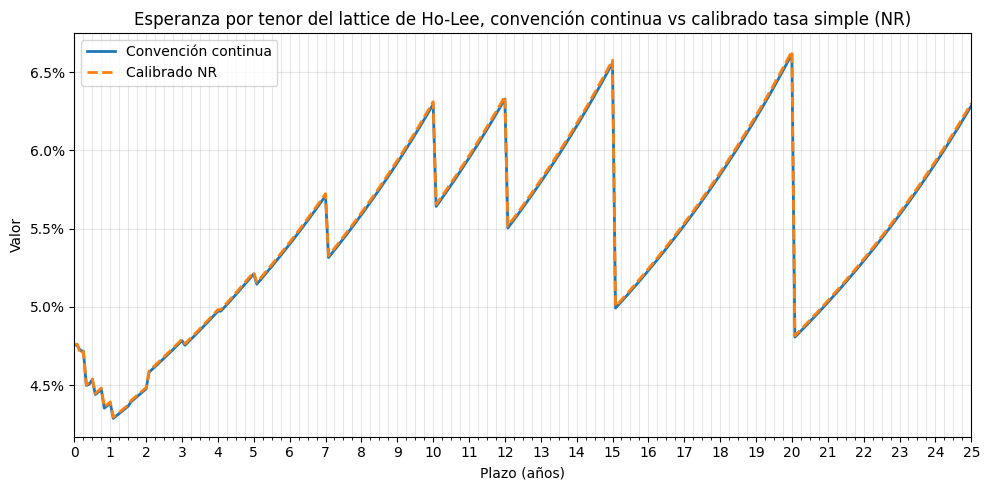

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

# mu_exp y mu_cal: listas/arrays de largo 301 (incluye t=0)
n = len(mu_exp)
assert len(mu_cal) == n, "Las dos series deben tener el mismo largo"

# eje x en años
x_years = np.arange(n) / 12.0  # 0, 1/12, 2/12, ..., 300/12

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_years, mu_exp, label="Convención continua", lw=2)
ax.plot(x_years, mu_cal, label="Calibrado NR", lw=2, linestyle="--")

ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Valor")  # cambia a "Tasa" si corresponde
ax.set_xlim(0, (n-1)/12)

# Ticks: mayor cada 1 año, menor cada 0.25 años
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))


# Si son tasas en DECIMAL, descomenta para ver %:
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

ax.set_title("Esperanza por tenor del lattice de Ho-Lee, convención continua vs calibrado tasa simple (NR)")

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


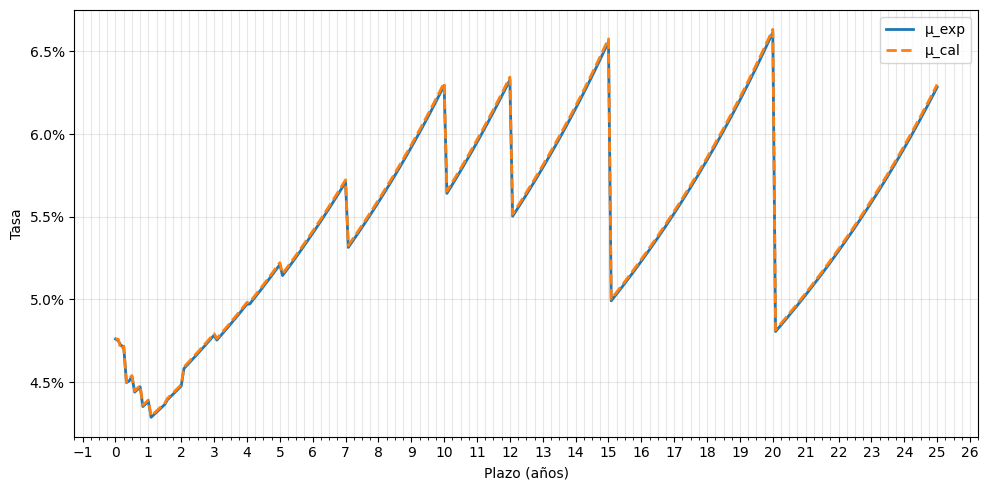

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

n = len(mu_exp)
x_years = np.arange(n) / 12.0

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_years, mu_exp, label="μ_exp", lw=2)
ax.plot(x_years, mu_cal, label="μ_cal", lw=2, ls="--")

ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Tasa")
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

# <<< Aquí conviertes de decimal a porcentaje en los ticks >>>
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))
# (ajusta `decimals=` si quieres más/menos decimales)

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [14]:
import numpy as np

# =========================
# Utilitarios del árbol
# =========================

def check_triangular(r: np.ndarray):
    n = r.shape[0] - 1
    assert r.shape[1] == n+1, "r debe ser (n+1, n+1)"
    # Solo chequeo básico: r[i,j] definido para i<=j
    for j in range(n+1):
        for i in range(j+1, n+1):
            assert not np.isfinite(r[i, j]), "r[i>j, j] debe ser NaN"

def discount_simple(r_ij: float, alpha_j: float) -> float:
    """DF = 1 / (1 + α_j * r_{i,j})  (descuento simple)."""
    den = 1.0 + alpha_j * r_ij
    if den <= 0.0:
        # protección numérica/económica
        raise ValueError(f"Denominador no positivo en DF: 1+alpha*r={den:.6g}")
    return 1.0 / den

# =========================
# Backward genérico (sin prepago)
# =========================
def price_straight_tree(r: np.ndarray, alpha: np.ndarray, payments: np.ndarray) -> float:
    """
    Valora el crédito sin prepago.
    r: (n+1 x n+1) triangular (NaN fuera), r[i,j] en DECIMAL
    alpha: shape (n,), fracción de año del paso j->j+1
    payments: shape (n,), A_{j+1} pagado al final del paso j->j+1
    return: V_0 (valor hoy)
    """
    check_triangular(r)
    n = r.shape[0] - 1
    assert len(alpha) == n and len(payments) == n

    # Valor terminal post último pago: 0
    V_next = np.zeros(n+1)  # capa j=n (todos 0)

    # Backward: j = n-1, ..., 0
    for j in reversed(range(n)):
        V = np.zeros(j+1)
        for i in range(j+1):
            DF = discount_simple(r[i, j], alpha[j])
            cont = 0.5 * (V_next[i] + V_next[i+1]) + payments[j]  # EV bajo p=0.5
            V[i] = DF * cont
        V_next = V
    return float(V_next[0])

# =========================
# Backward con prepago (Bermudana)
# =========================
def price_callable_tree(
    r: np.ndarray,
    alpha: np.ndarray,
    payments: np.ndarray,
    prepay_cost: np.ndarray,
    can_prepay: np.ndarray
) -> float:
    """
    Valora el crédito con opción de prepago (Bermudana).
    prepay_cost[j] = K_{j+1} (monto a pagar si se ejerce al final del paso j->j+1)
    can_prepay[j] = True si en esa fecha existe derecho a prepagar
    """
    check_triangular(r)
    n = r.shape[0] - 1
    assert len(alpha) == n and len(payments) == n
    assert len(prepay_cost) == n and len(can_prepay) == n

    V_next = np.zeros(n+1)  # terminal 0

    for j in reversed(range(n)):
        V = np.zeros(j+1)
        for i in range(j+1):
            DF = discount_simple(r[i, j], alpha[j])
            cont = DF * (0.5 * (V_next[i] + V_next[i+1]) + payments[j])
            if can_prepay[j]:
                ex = DF * prepay_cost[j]
                V[i] = min(cont, ex)  # deudor elige lo más barato (ejercer o seguir)
            else:
                V[i] = cont
        V_next = V
    return float(V_next[0])

# =========================
# PV01 (anualidad) en el árbol
# =========================
def tree_annuity_pv01(r: np.ndarray, alpha: np.ndarray, pay_idx: np.ndarray) -> float:
    """
    PV, bajo la misma medida, de pagar 1 unidad en cada fecha indicada por pay_idx.
    pay_idx: bool array shape (n,) -> True donde hay pago de 1
    Sirve para convertir el valor de la opción a 'bps' ≈ (Vstraight - Vcallable)/PV01 * 1e4
    """
    n = r.shape[0] - 1
    assert len(alpha) == n and len(pay_idx) == n
    unit_pay = np.where(pay_idx, 1.0, 0.0)
    return price_straight_tree(r, alpha, unit_pay)

# =========================
# Wrapper completo de valorización
# =========================
def price_with_and_without_prepay(
    r: np.ndarray,
    alpha: np.ndarray,
    payments: np.ndarray,
    prepay_cost: np.ndarray,
    can_prepay: np.ndarray,
    pv01_mask: np.ndarray = None
):
    """
    Devuelve:
      V_callable, V_straight, option_value, option_spread_bps
    """
    V_call = price_callable_tree(r, alpha, payments, prepay_cost, can_prepay)
    V_str  = price_straight_tree(r, alpha, payments)
    opt_val = V_str - V_call

    if pv01_mask is None:
        # por defecto, PV01 sobre todas las fechas con pago contractual
        pv01_mask = (payments != 0.0)

    ann = tree_annuity_pv01(r, alpha, pv01_mask)
    opt_bps = (opt_val / ann) * 1e4 if ann > 0 else np.nan
    return V_call, V_str, opt_val, opt_bps


In [20]:
def compute_prepay_cost_chile(
    saldo_pre: np.ndarray,     # len = months+1; saldo de capital al inicio de cada mes (antes de intereses)
    interes_mes: np.ndarray,   # len = months; interés del mes sobre saldo_pre[t]
    monthly_coupon: float,     # tasa mensual contractual del crédito (nominal/12)
    is_indexed: bool,          # True -> reajustable (1.5 meses); False -> no reajustable (1 mes)
    uf_to_clp: float | None = None,  # CLP por UF para aplicar el tope (si None, no se aplica tope)
    uf_cap: float = 5000.0,
    include_due_interest: bool = True,   # si el ejercicio reemplaza a la cuota, agrega el interés del mes
) -> np.ndarray:
    """
    Retorna K[j] (j=0..months-1) para comparar al final del mes j:
      K[j] = capital_prepagado + comisión (+ interés del mes si corresponde)
    capital_prepagado (prepago total) = saldo_pre[j].
    Comisión = m * monthly_coupon * capital, con m=1 (no reajustable) o 1.5 (reajustable), tope UF 5.000.
    """
    months = len(interes_mes)
    K = np.zeros(months, dtype=float)

    mult = 1.5 if is_indexed else 1.0

    for j in range(months):
        capital = saldo_pre[j]                   # capital que se prepaga (prepago total)
        comision = mult * monthly_coupon * capital  # m * 1 mes de interés (o 1.5)

        # Tope regulatorio
        if uf_to_clp is not None:
            comision = min(comision, uf_cap * uf_to_clp)

        K[j] = capital + comision
        if include_due_interest:
            # si el ejercicio sustituye a la cuota del mes, sumo el interés devengado del mes j
            K[j] += interes_mes[j]

    return K

def build_mortgage_inputs(
    principal: float = 100_000_000.0,  # capital inicial (CLP)
    annual_coupon: float = 0.06,       # tasa anual del cliente (nominal)
    months: int = 240,                 # 20 años
    daycount_30_360: bool = True,      # mensual 30/360: α=1/12
    lockout_months: int = 0,           # meses sin derecho a prepagar
    fee_schedule: str = "flat",        # "flat" o "step"
    fee_flat: float = 0.02             # 2% flat si fee_schedule="flat"
):
    """
    Devuelve:
      alpha        : (months,)  1/12 cada paso (si 30/360)
      payments     : (months,)  cuota mensual (constante)
      prepay_cost  : (months,)  K_{j+1} = saldo antes de la cuota del mes j+1, con penalidad
      can_prepay   : (months,)  bool, True donde se permite prepagar
      schedule     : dict con arrays auxiliares (saldo_pre, interes, amort, saldo_post)
    """
    # 1) Fracción de año por paso
    if daycount_30_360:
        alpha = np.full(months, 1.0/12.0, dtype=float)
    else:
        # Si quisieras ACT/360 variable por mes, reemplaza por tus valores:
        raise NotImplementedError("ACT/360 mensual no implementado en este ejemplo")

    # 2) Tasa mensual contractual (francés). Usa nominal/12 (coincide con práctica local).
    i_m = annual_coupon / 12.0

    # 3) Cuota fija (si i_m=0, evita división por 0)
    if i_m > 0:
        A = principal * (i_m) / (1.0 - (1.0 + i_m)**(-months))
    else:
        A = principal / months

    payments = np.full(months, A, dtype=float)

    # 4) Recorrido determinista del saldo para obtener K_{j+1}
    saldo_pre  = np.zeros(months+1)  # saldo justo ANTES de pagar la cuota del mes t
    interes    = np.zeros(months)    # interés del mes
    amort      = np.zeros(months)    # amortización del mes
    saldo_post = np.zeros(months+1)  # saldo justo DESPUÉS de pagar la cuota del mes t

    saldo_pre[0] = principal
    for t in range(months):
        interes[t] = saldo_pre[t] * i_m
        amort[t]   = A - interes[t]
        saldo_post[t+1] = saldo_pre[t] - amort[t]
        saldo_pre[t+1]  = saldo_post[t+1]  # para el mes siguiente

    # 5) Penalidad de prepago
    if fee_schedule == "flat":
        fee = np.full(months, fee_flat, dtype=float)  # p.ej. 2% sobre saldo
    elif fee_schedule == "step":
        # Ejemplo escalonado: 2% los primeros 60 meses, 1% resto
        fee = np.where(np.arange(months) < 60, 0.02, 0.01).astype(float)
    else:
        raise ValueError("fee_schedule debe ser 'flat' o 'step'")

    # 6) K_{j+1} = saldo ANTES de la cuota del mes j+1 (== saldo_post[j]) * (1+fee_j)
    #    Nota: nuestro backward compara a fin de periodo:
    #      - Seguir: paga cuota A_{j+1}
    #      - Prepagar: en vez de la cuota, paga K_{j+1}
    i_m = annual_coupon / 12.0
    prepay_cost = compute_prepay_cost_chile(
        saldo_pre=schedule["saldo_pre"],   # del cronograma francés
        interes_mes=schedule["interes"], 
        monthly_coupon=i_m,
        is_indexed=False,                  # True si es reajustable (UF)
        uf_to_clp=valor_CLP_por_UF,        # ej. 36_000.0; o None si no quieres aplicar el tope
        uf_cap=5000.0,
        include_due_interest=True          # típico si el ejercicio reemplaza a la cuota del mes
    )
    # 7) Fechas habilitadas para prepagar
    can_prepay = np.ones(months, dtype=bool)
    if lockout_months > 0:
        can_prepay[:lockout_months] = False

    schedule = dict(
        saldo_pre  = saldo_pre,   # len = months+1 (t=0..months)
        interes    = interes,     # len = months
        amort      = amort,       # len = months
        saldo_post = saldo_post   # len = months+1
    )
    return alpha, payments, prepay_cost, can_prepay, schedule

# ===== Ejemplo de uso =====
alpha, payments, prepay_cost, can_prepay, sched = build_mortgage_inputs(
    principal=120_000_000.0,  # CLP
    annual_coupon=0.055,      # 5.5% nominal anual del cliente
    months=300,               # 25 años
    daycount_30_360=True,     # α=1/12
    lockout_months=12,        # sin prepago el primer año
    fee_schedule="flat",
    fee_flat=0.02             # 2% flat sobre saldo
)

print("alpha[0:5]      =", alpha[:5])
print("payments[0:3]   =", payments[:3])
print("prepay_cost[0:3]=", prepay_cost[:3])
print("can_prepay[:15] =", can_prepay[:15])
print("saldo_pre[0:4]  =", sched["saldo_pre"][:4])
print("saldo_post[0:4] =", sched["saldo_post"][:4])


UnboundLocalError: cannot access local variable 'schedule' where it is not associated with a value

In [21]:
# Supón:
# - r: tu lattice (n+1 x n+1) con NaN fuera de i<=j
# - alpha: vector (n,) con 1/12 si 30/360 mensual (o ACT/360 días/360)
# - payments: flujo contractual A_{j+1}
# - prepay_cost: K_{j+1} (saldo + fee/“costos de quiebre”)
# - can_prepay: bool (n,) True en fechas con derecho a prepagar
alpha = np.array(1/12 for i in range(N))
    


V_call, V_str, opt_val, opt_bps = price_with_and_without_prepay(
    r, alpha, payments, prepay_cost, can_prepay
)
print("Callable  :", V_call)
print("Straight  :", V_str)
print("Opción ($):", opt_val)
print("Opción (bps):", opt_bps)


AssertionError: r[i>j, j] debe ser NaN

array([[0.04761   , 0.01502507, 0.01363372, 0.01302391, 0.01155239],
       [0.        , 0.01670861, 0.01531726, 0.01470746, 0.01323593],
       [0.        , 0.        , 0.01700081, 0.016391  , 0.01491948],
       [0.        , 0.        , 0.        , 0.01807454, 0.01660302],
       [0.        , 0.        , 0.        , 0.        , 0.01828656]])

In [36]:
df1 = pd.DataFrame(r, index=[i for i in range(N+1)],
                   columns=[j for j in range(N+1)])
df1.to_excel("output.xlsx")  

